In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from collections import deque

In [ ]:
"""
for google colab support
"""

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/BA/Cure/4Colors'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Compare4ColorsCureipynb.ipynb', 'CompareStrat14Color.ipynb', 'Cure4Color.ipynb', 'Cure4ColorMulStrats.ipynb', 'Cure4ColorRandom2.0.ipynb', 'MulCompare.ipynb', 'SumCompare.ipynb', 'cities.csv', 'combined_SUM_Cure.csv', 'combined_SUM_Cure_Cure.csv', 'combined_SUM_DC_sum_Cure.csv', 'combined_SUM_DC_sum_Cure_Cure.csv', 'combined_SUM_DC_sum_repeat_Cure.csv', 'combined_SUM_DC_sum_repeat_Cure_Cure.csv', 'combined_SUM_repeat_Cure.csv', 'combined_SUM_repeat_Cure_Cure.csv', 'combined_repeat_Cure.csv', 'combinedcompare.ipynb', 'disease_counters.csv', 'disinfect_combined_mul_Cure.csv', 'disinfect_combined_mul_Cure_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_Cure_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_repeat_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_repeat_Cure_Cure.csv', 'disinfect_combined_mul_repeat_Cure.csv', 'disinfect_combined_mul_repeat_Cure_Cure.csv', 'edges.csv', 'mos

In [ ]:
strategies = [
              "combined_SUM",
              "combined_SUM_Cure",
              "combined_SUM_DC_sum_Cure"]


num_simulations = 10000

k_actions_range = range(9)

epidemic_cards = [0,1,2,3,4,5,6]


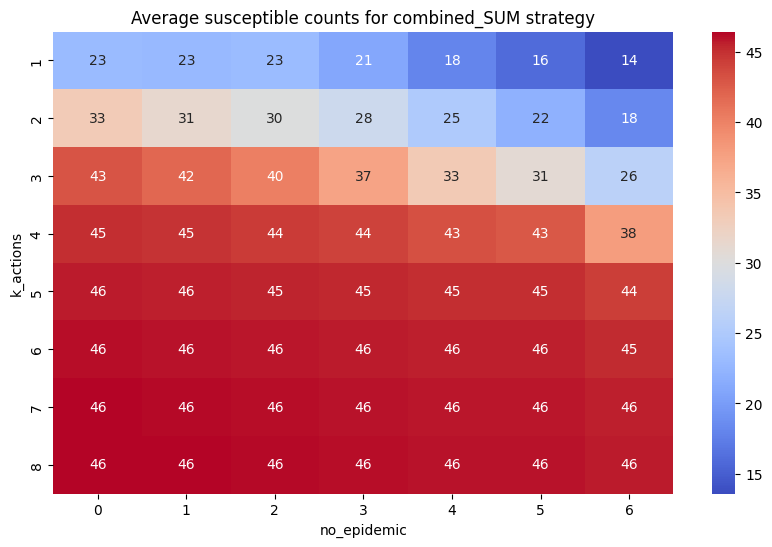

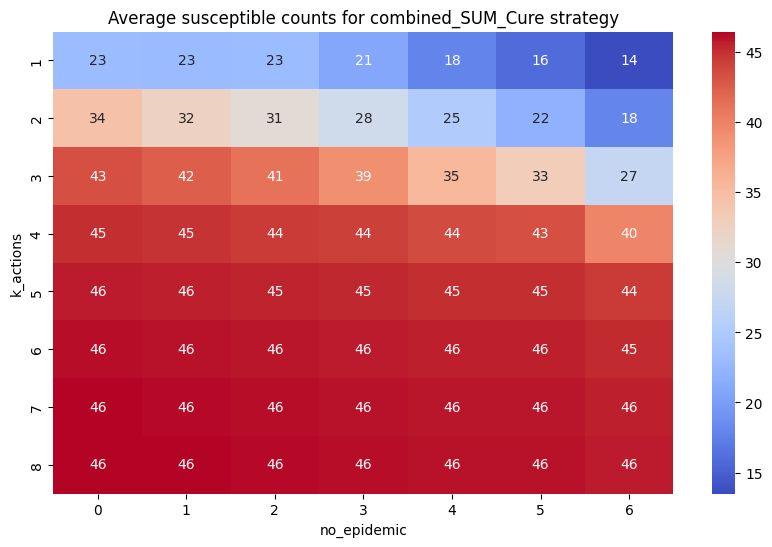

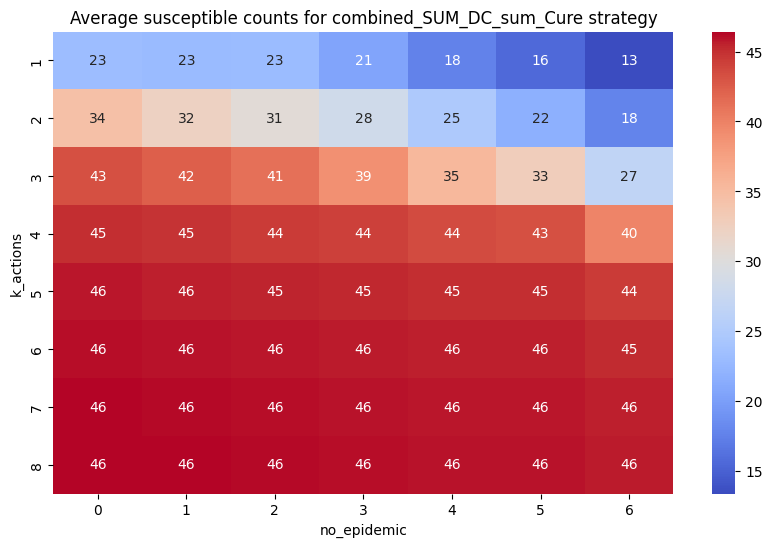

In [ ]:
#@title All strategies average susceptible counts heatmap

for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store average susceptible counts
    avg_susceptible_counts = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            # Calculate the average susceptible count for each run in the filtered DataFrame
            avg_susceptible_per_run = filtered_df.groupby('run')['susceptible_nodes'].mean()

            # Calculate the average susceptible count across all runs
            avg_susceptible = avg_susceptible_per_run.mean()

            # Store the average susceptible count in the 2D array
            avg_susceptible_counts[j, i] = avg_susceptible

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(avg_susceptible_counts, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    plt.title(f'Average susceptible counts for {strategy} strategy')
    #plt.title(f'Average susceptible counts for {strategy} strategy')
    plt.show()


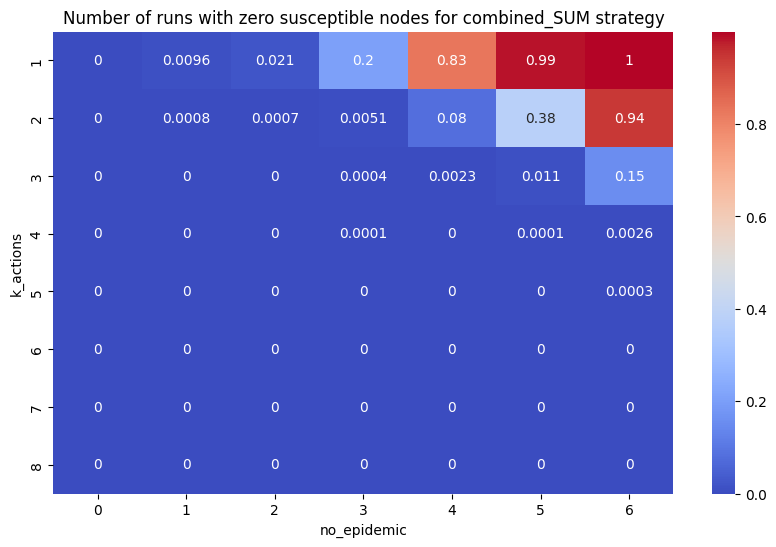

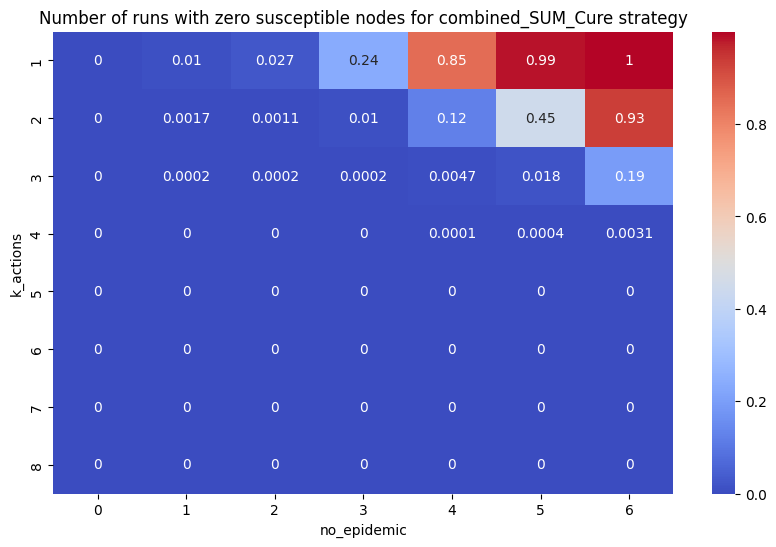

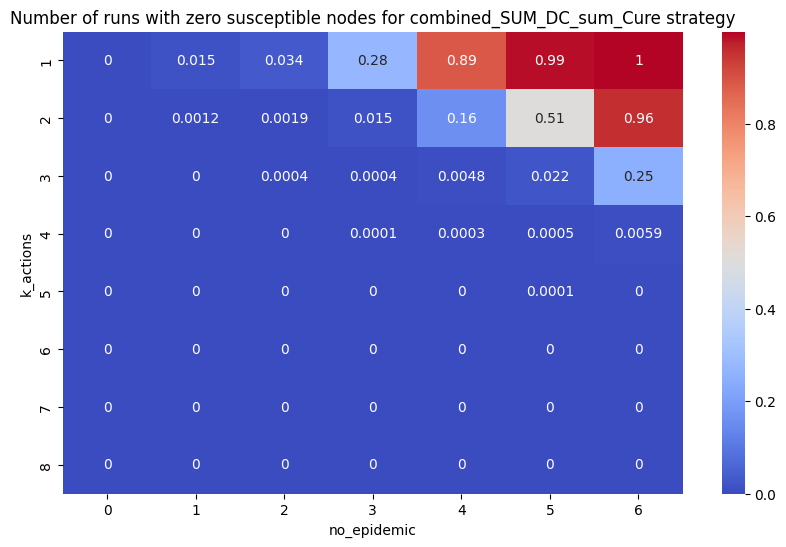

In [ ]:
#@title All strategies zero susceptible counts heatmap

for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store counts of runs with zero susceptible nodes
    zero_susceptible_counts = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            # Initialize counter for runs with zero susceptible nodes
            zero_susceptible_runs = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Check if any timestep within the run has 0 susceptible nodes
                if (run['susceptible_nodes'] == 0).any():
                    zero_susceptible_runs += 1

            # Store the count in the 2D array
            zero_susceptible_counts[j, i] = zero_susceptible_runs / 10000

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(zero_susceptible_counts, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    plt.title(f'Number of runs with zero susceptible nodes for {strategy} strategy')
    #plt.title(f'Number of runs with zero susceptible nodes for {strategy} strategy')
    plt.show()


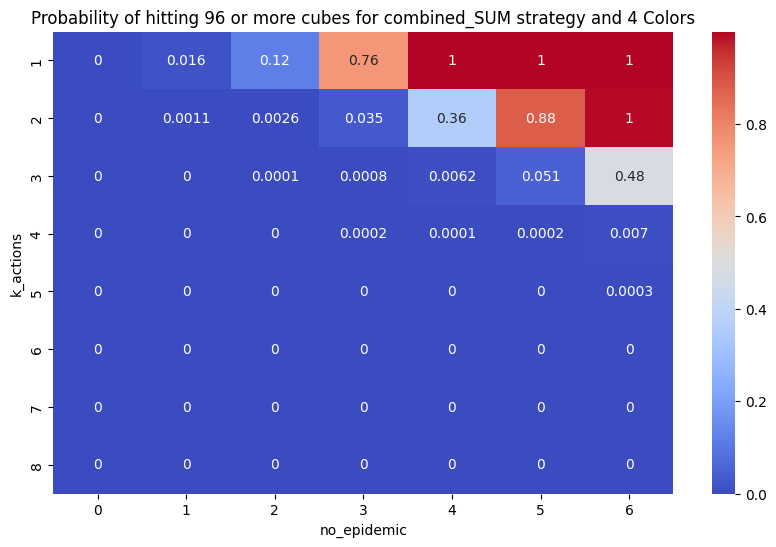

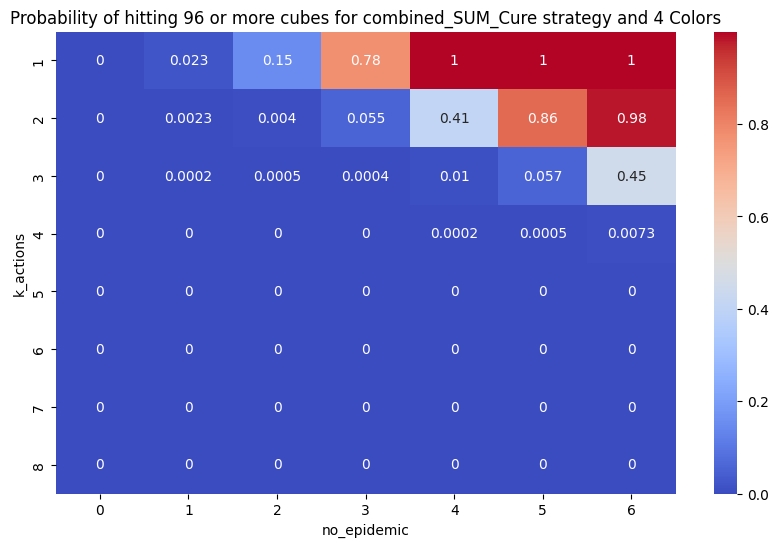

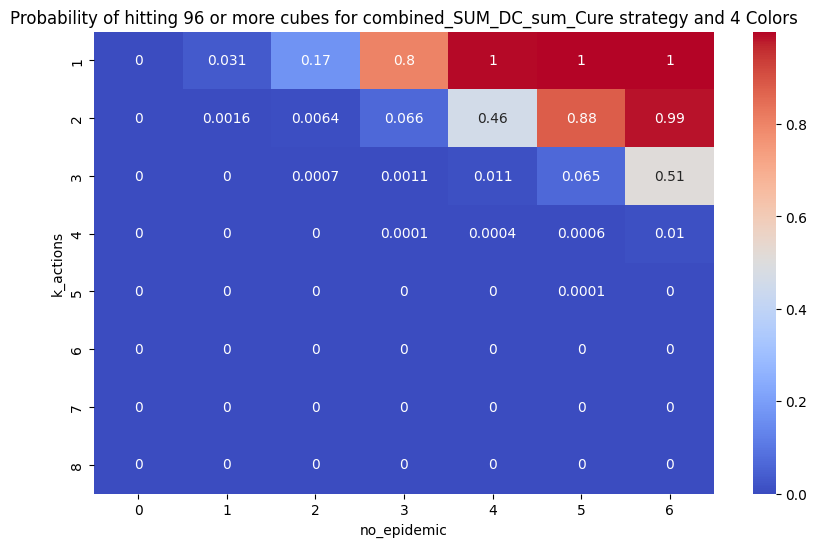

In [ ]:

for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            # Initialize counter for this combination
            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Calculate the total number of cubes for each timestep in the run
                total_cubes_per_timestep = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'] +
                                            run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'] +
                                            run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'] +
                                            run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
                # Check if any timestep within the run has 96 or more cubes
                if (total_cubes_per_timestep >= 96).any():
                    count += 1

            # Calculate the probability
            probability = count / 10000

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    #plt.title(f'Probability of hitting 96 or more cubes for {strategy} strategy and 4 Colors')
    plt.title(f'Probability of hitting 96 or more cubes for {strategy} strategy and 4 Colors')

    plt.show()

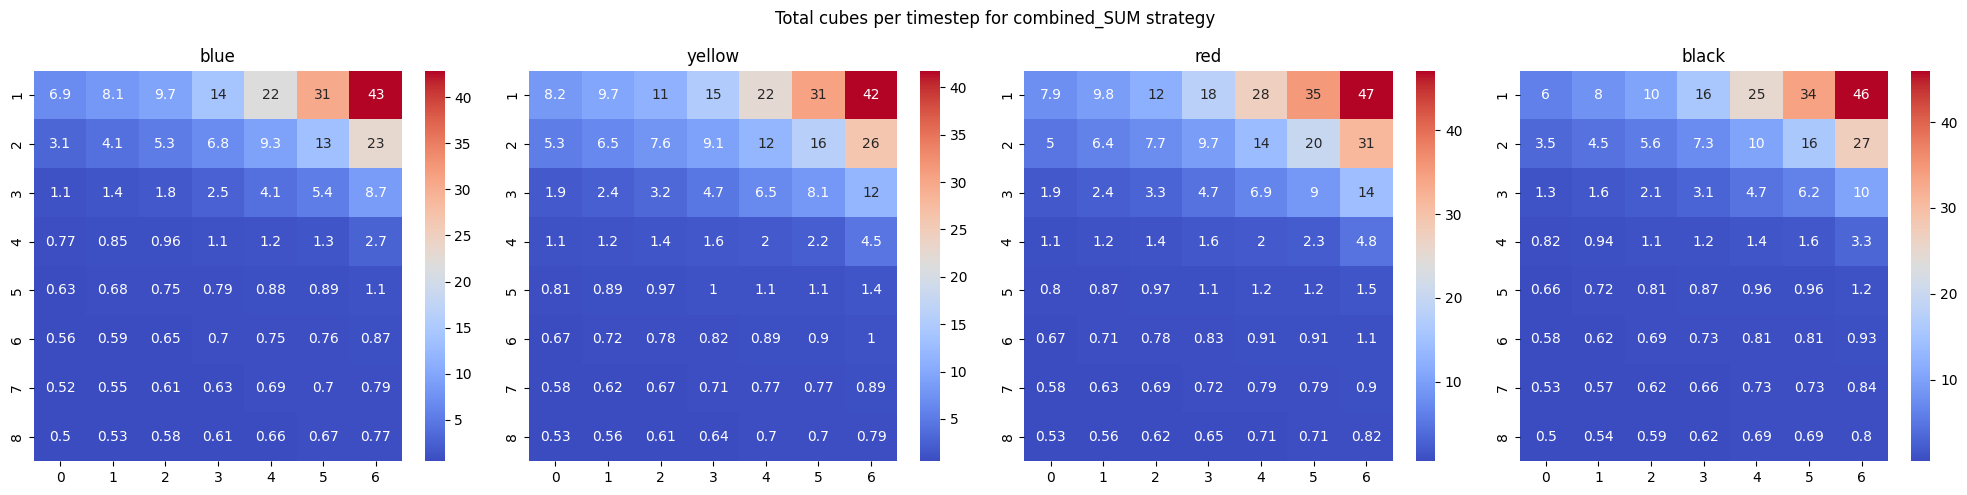

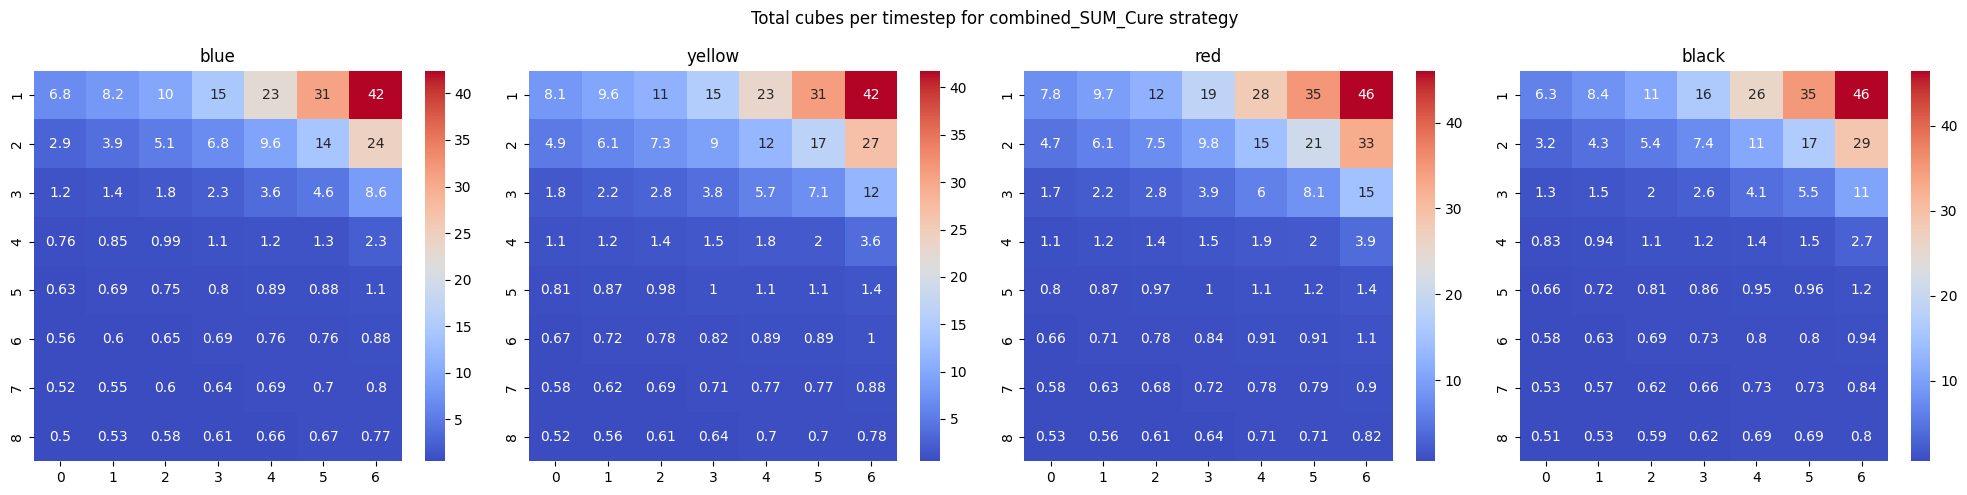

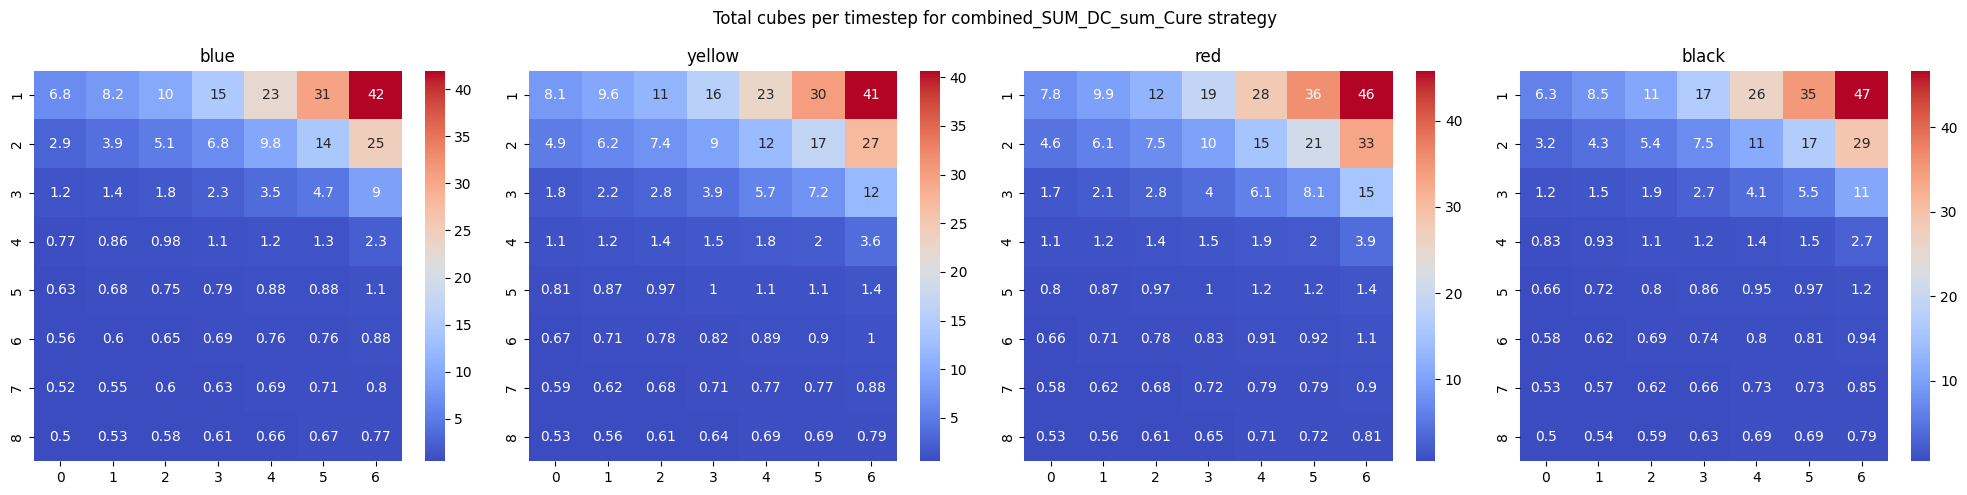

In [ ]:
#@title 4 color counter

colors = ['blue', 'yellow', 'red', 'black']

for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for ax, color in zip(axs, colors):
        # Initialize a 2D array to store total cubes per timestep for each color
        total_cubes_per_timestep = np.zeros((len(unique_k_actions), len(epidemic_cards)))

        # Iterate over all combinations of 'no_epidemic' and 'k_actions'
        for i, no_epi in enumerate(epidemic_cards):
            for j, k_act in enumerate(unique_k_actions):
                # Filter the DataFrame based on the current combination
                filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

                # Calculate total cubes per timestep for each color
                total_cubes_per_timestep[j, i] = (filtered_df[f'infection_1_nodes_{color}'] + 2 * filtered_df[f'infection_2_nodes_{color}'] + 3 * filtered_df[f'infection_3_nodes_{color}']).mean()

        # Create the heatmap
        sns.heatmap(total_cubes_per_timestep, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions, ax=ax)
        ax.set_title(color)

    #plt.suptitle(f'Total cubes per timestep for {strategy} strategy')
    plt.suptitle(f'Total cubes per timestep for {strategy} strategy')

    plt.tight_layout()
    plt.show()


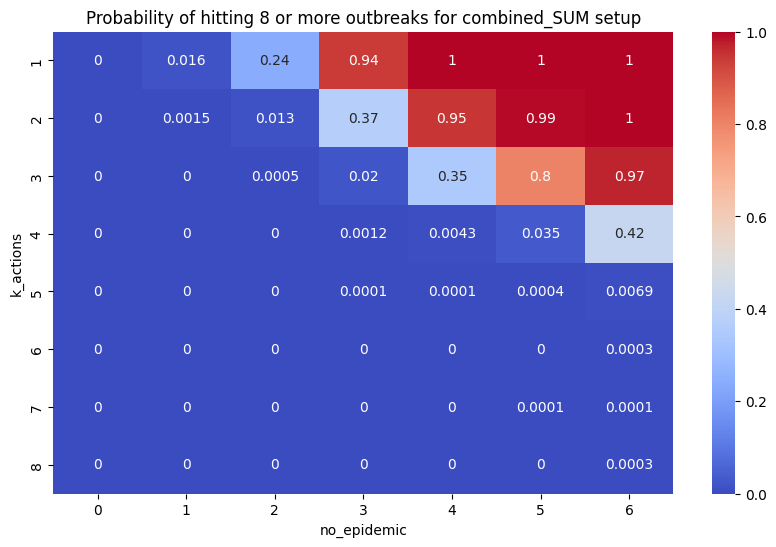

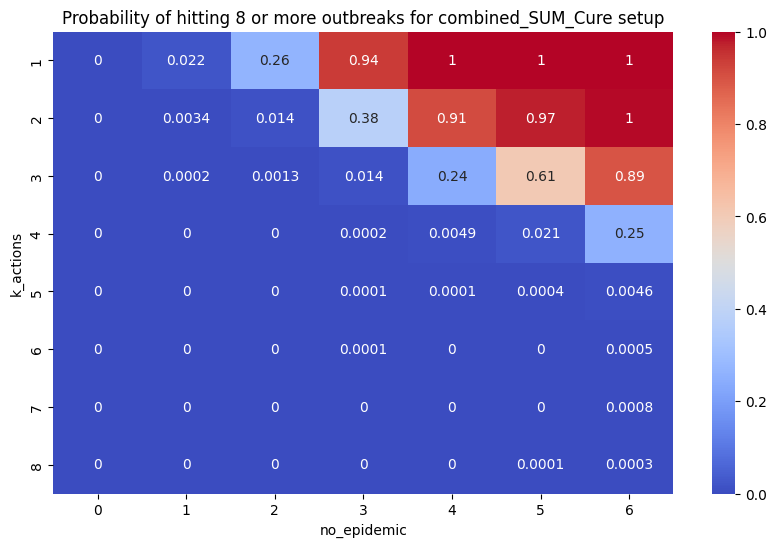

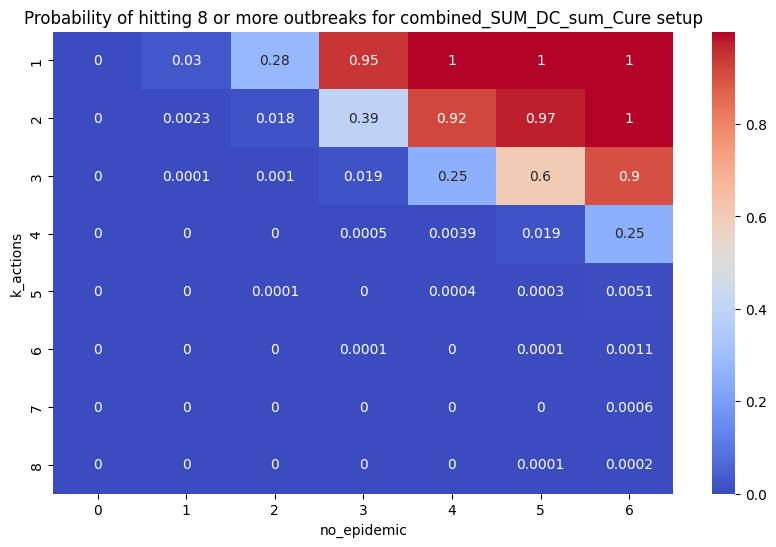

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Check if any timestep within the run meets the condition
                if (run["outbreaks"] >= 8).any():
                    count += 1

            # Calculate the probability
            probability = count / 10000

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)  # Adjusted labels
    plt.xlabel('no_epidemic')  # Adjusted label
    plt.ylabel('k_actions')  # Adjusted label
    #plt.title(f'Probability of hitting {8} or more outbreaks for {strategy} setup')
    plt.title(f'Probability of hitting {8} or more outbreaks for {strategy} setup')

    #plt.savefig((f'{setup_name}_OneColor_Heatmap_8_or_more_Outbreaks.png'))
    plt.show()

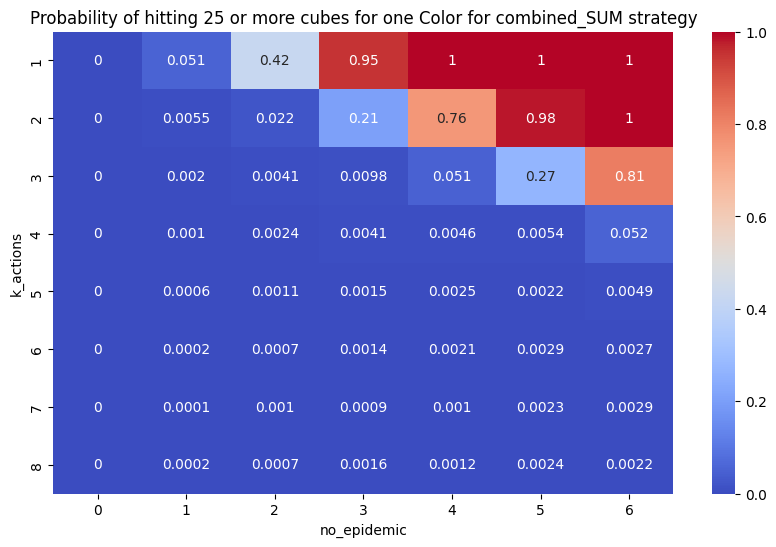

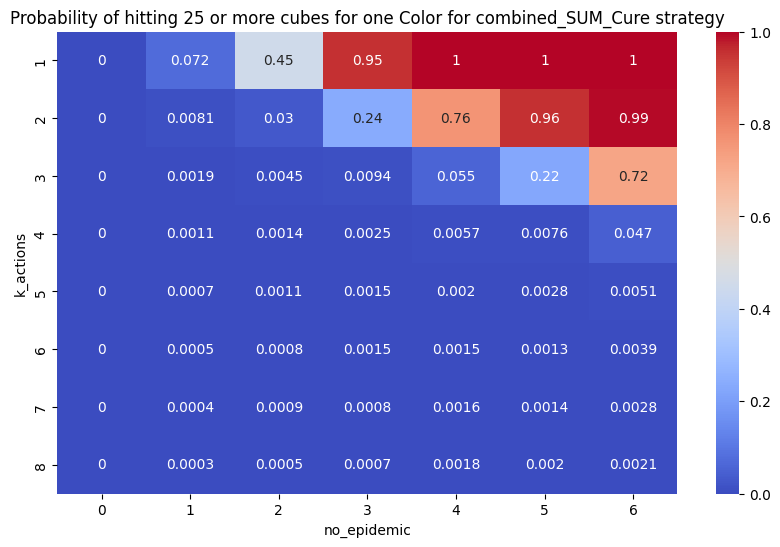

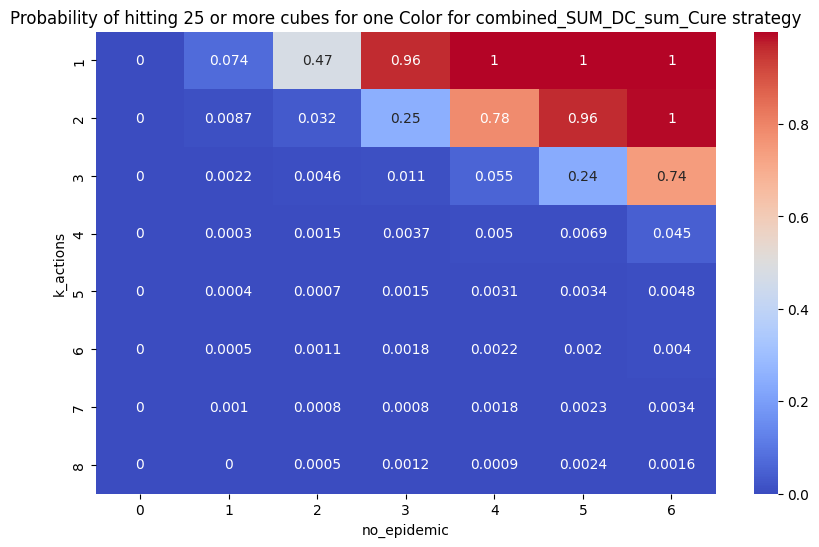

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            # Initialize counter for this combination
            # I dont know any heatmap that i could divide into 4 counters for each epi and k_action
            # So I used the normal count var
            blue_count = 0
            yellow_count = 0
            red_count = 0
            black_count = 0
            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Calculate the total number of cubes for each timestep in the run
                blue_cubes = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'])
                yellow_cubes = (run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'])
                red_cubes = (run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'])
                black_cubes = (run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
                # Check if any timestep within the run has 96 or more cubes
                #if (blue_cubes >= 25 or yellow_cubes >= 25 or red_cubes >= 25 or black_cubes >= 25).any():
                #    count += 1
                if (blue_cubes >= 25).any():
                    count += 1
                elif (yellow_cubes >= 25).any():
                    count += 1
                elif (red_cubes >= 25).any():
                    count += 1
                elif (black_cubes >= 25).any():
                    count += 1

            # Calculate the probability
            probability = count / 10000

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    #plt.title(f'Probability of hitting 25 or more cubes for one Color for {strategy} strategy')
    plt.title(f'Probability of hitting 25 or more cubes for one Color for {strategy} strategy')

    plt.show()

In [ ]:
def calculate_eradicated_true_heatmap(df, setup_name):
    # Define the unique values of 'no_epidemic' and 'k_actions'
    unique_no_epidemics = sorted(df['no_epidemic'].unique())
    unique_k_actions = sorted(df['k_actions'].unique())

    colors = ['blue', 'yellow', 'red', 'black']
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for ax, color in zip(axs, colors):
        # Initialize a 2D array to store probabilities
        probabilities = np.zeros((len(unique_k_actions), len(unique_no_epidemics)))  # Swapping dimensions

        # Iterate over all combinations of 'no_epidemic' and 'k_actions'
        for i, no_epi in enumerate(unique_no_epidemics):
            for j, k_act in enumerate(unique_k_actions):  # Adjusted indices
                # Filter the DataFrame based on the current combination
                filtered_df = df[(df['no_epidemic'] == no_epi) & (df['k_actions'] == k_act)]

                # Initialize counter for this combination
                count = 0

                # Iterate over each run in the filtered DataFrame
                for _, run in filtered_df.groupby('run'):
                    # Check if any timestep within the run meets the condition
                    if (run[f'eradicated_{color}'] == True).any():
                        count += 1

                # Calculate the probability
                probability = count / 10000

                # Store the probability in the 2D array
                probabilities[j, i] = probability

        # Create the heatmap
        sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=unique_no_epidemics, yticklabels=unique_k_actions, ax=ax)  # Adjusted labels
        ax.set_title(color)

    plt.suptitle(f'Probability of eradicated being True for {strategy} setup')
    plt.tight_layout()
    plt.show()


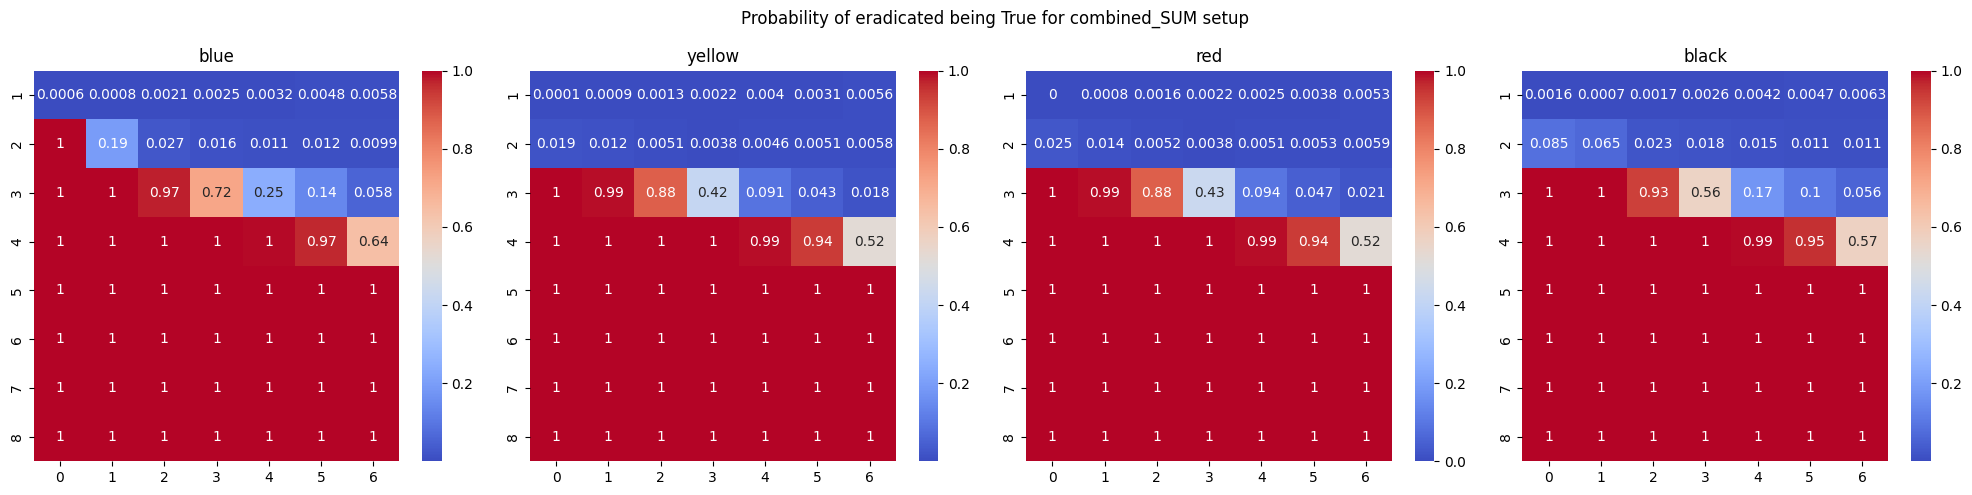

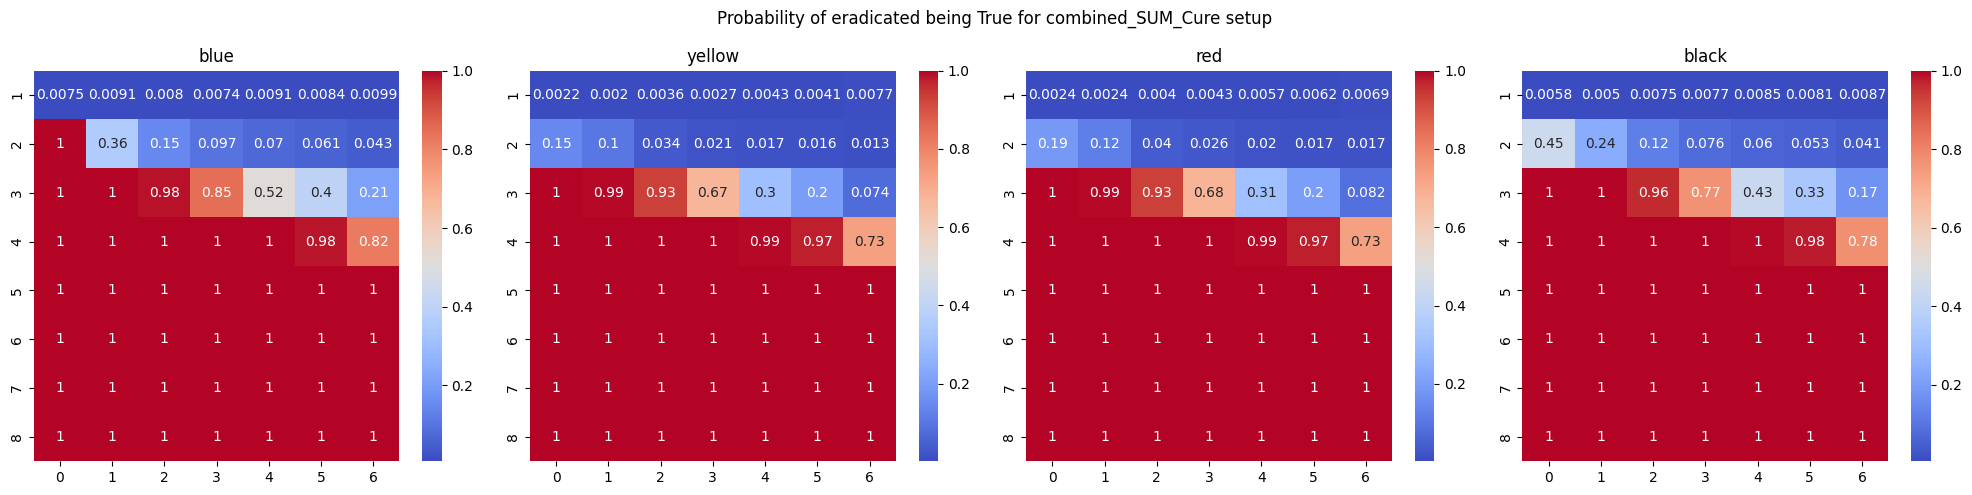

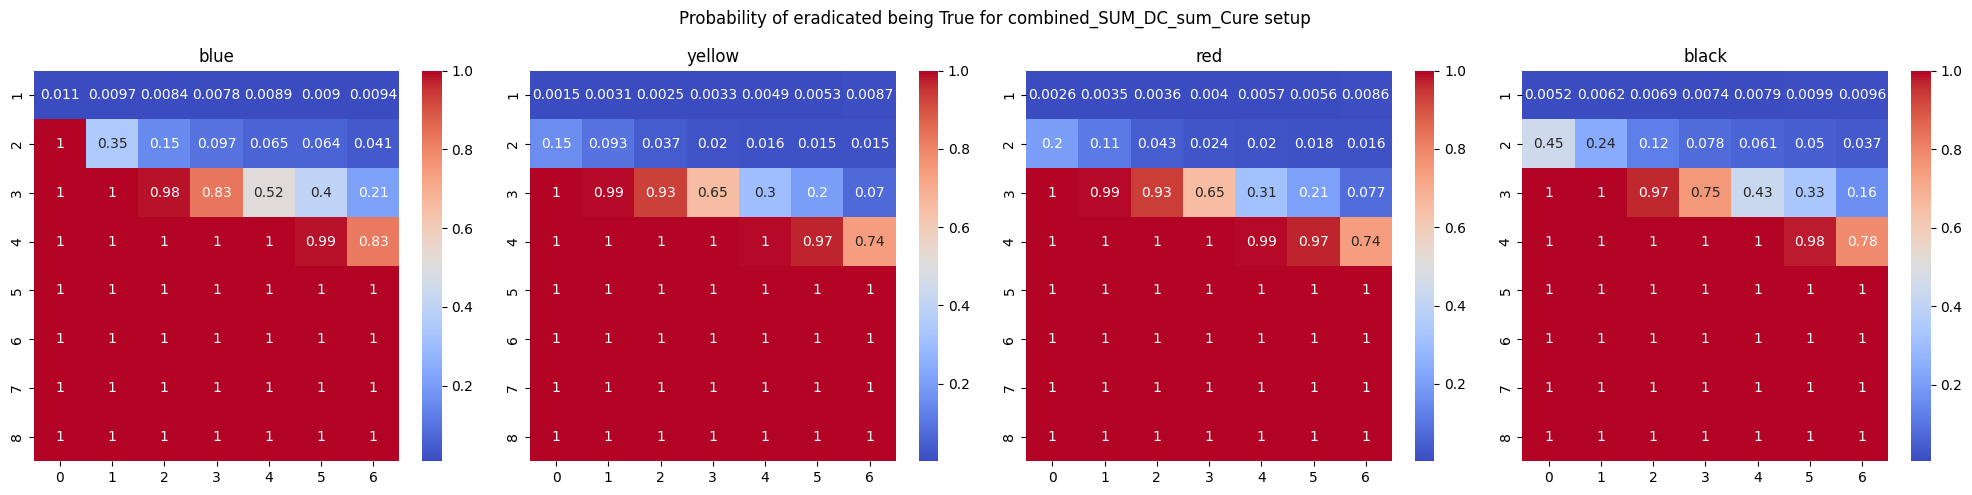

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    # Define the setup name
    setup_name = strategy

    # Call the function with your baseline_df and setup_name
    calculate_eradicated_true_heatmap(strategy_df, setup_name)

In [ ]:
def calculate_avg_eradication_timestep_heatmap(df, setup_name):
    # Define the unique values of 'no_epidemic' and 'k_actions'
    unique_no_epidemics = sorted(df['no_epidemic'].unique())
    unique_k_actions = sorted(df['k_actions'].unique())

    colors = ['blue', 'yellow', 'red', 'black']
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for ax, color in zip(axs, colors):
        # Initialize a 2D array to store average eradication timesteps
        avg_eradication_timesteps = np.full((len(unique_k_actions), len(unique_no_epidemics)), -1)

        # Iterate over all combinations of 'no_epidemic' and 'k_actions'
        for i, no_epi in enumerate(unique_no_epidemics):
            for j, k_act in enumerate(unique_k_actions):
                # Filter the DataFrame based on the current combination
                filtered_df = df[(df['no_epidemic'] == no_epi) & (df['k_actions'] == k_act)]

                # Initialize a list to store eradication timesteps for each run
                eradication_timesteps = []

                # Iterate over each run in the filtered DataFrame
                for _, run in filtered_df.groupby('run'):
                    # Check if the disease is eradicated within the run
                    if (run[f'eradicated_{color}'] == True).any():
                        # Find the first timestep where the disease is eradicated
                        eradication_timestep = run[run[f'eradicated_{color}'] == True]['timestep'].min()
                        eradication_timesteps.append(eradication_timestep)

                # If there are eradication timesteps, calculate the average
                if eradication_timesteps:
                    avg_eradication_timesteps[j, i] = np.mean(eradication_timesteps)

        # Create the heatmap
        sns.heatmap(avg_eradication_timesteps, cmap='coolwarm', annot=True, fmt=".1f",
                    xticklabels=unique_no_epidemics, yticklabels=unique_k_actions, ax=ax, cbar_kws={'label': 'Average Eradication Timestep'})
        ax.set_title(color)

    plt.suptitle(f'Average eradication timestep for {strategy} setup')
    plt.tight_layout()
    plt.show()


In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_Cure.csv')

    # Define the setup name
    setup_name = strategy

    # Call the function with your baseline_df and setup_name
    calculate_eradicated_true_heatmap(strategy_df, setup_name)